# Tutorial 1: Gaussian Process Model for Interpolation

In this notebook, we will walk through the functionalities of the developed package related to training and exploiting a Gaussian Process model for interpolation purposes. 

For a theoretical introduction of the Gaussian Process modeling, please check out this blog post in Towards Data Science: [Implement A Gaussian Process From Scratch](https://towardsdatascience.com/implement-a-gaussian-process-from-scratch-2a074a470bce). This [cheatsheet](https://github.com/ShuaiGuo16/Gaussian-Process/blob/master/GP_cheatsheet.pdf) summarizes the main formulas used in deriving a Gaussian Process model. 

If you have further questions, please contact Shuai Guo at guo@tfd.mw.tum.de

In [1]:
# Set module path
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\GaussianProcess")

In [2]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Import GP interpolation module
from GPInterpolator import GPInterpolator

%matplotlib inline

## 1. One-dimensional analytical function

In this tutorial, the first reference problem we considered is to interpolate a one-dimensional analytical function:

\begin{equation}
y = (6x-2)^2sin(12x-4), x \in [0,1]
\end{equation}

In [3]:
# Define 1D function
def Test_1D(X):
    """1D Test Function"""
    
    y = (X*6-2)**2*np.sin(X*12-4)
    
    return y

### 1.1 Generate training/testing dataset

In [4]:
# Training data
X_train = np.array([0.0, 0.15, 0.3, 0.54, 0.7, 0.8, 1]).reshape(-1,1)
y_train = Test_1D(X_train)

# Testing data
X_test = np.linspace(0.0, 1, 100).reshape(-1,1)
y_test = Test_1D(X_test)

### 1.2 Initiate a GPInterpolator class 

To train a Gaussian Process (GP) model and later use it for performing interpolating tasks, we first need to initiate a `GPInterpolator` class. There are several parameters need to be specified in determining how the GP model is constructed and trained. Those parameters include:

1. `n_restarts`: integer, number of local optimizers used for GP model parameter tuning. This parameter exists because the current Gaussian Process package employed a multi-start strategy to optimize the model parameter globally, i.e., random starting points are generated in the search space and each starting point is assigned to one local optimizer to find identify the local optimum around that starting point. The default value for `n_restarts` is 20. In general, a larger `n_restarts` number improve the chance of locating the global optimum.

2. `opt`: dictionary, indicates the algorithms used by the local optimizer and specify whether or not gradients will be used to accelerate optimization. The default value for `opt` is `{'optimizer':'L-BFGS-B', 'jac': True}`, representing that we use ["L-BFGS-B"](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html) algorithm and we provide gradients for optimization. Under the hood, `SciPy.optimize.minimize` package is used to perform optimization. For other available methods, please refer to the [official documentations](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize).

3. `inital_point`: array, user-specified starting points for model parameter optimization. The default value is `None`, meaning that the GP package will automatically handle the starting-point generation for user. However, a user might want to manually specify a starting point when s/he has the prior knowledge about where the optimum parameter value may be located. 

4. `verbose`: bool, determins whether to display optimization results, default value is False, i.e., not displaying the results.

5. `kernel`: str, determins which kernel to use for GP model. Currently available options include **Gaussian**, **Matern-3_2**, **Matern-5_2**, **Cubic**. The default is Gaussian kernel.

6. `trend`: str, determins which global trend type to use for GP model. Currently available options include **Const**, **Linear**, **Quadratic**, and user-specify.

7. `nugget`: float, the nugget term to be added to the diagonal of the kernel matrix. This practice can avoid numerical instability when coverting the kernel matrix. The default value is $10^{-10}$.

Here, we use the default settings, but you can also explore other combinations.

In [5]:
GP = GPInterpolator(trend='Const', kernel='Gaussian', verbose=False)

In [6]:
# Check default attributes
GP.__dict__

{'verbose': False,
 'n_restarts': 20,
 'opt': {'optimizer': 'L-BFGS-B', 'jac': True},
 'init_point': None,
 'kernel': 'Gaussian',
 'trend': 'Const',
 'nugget': 1e-10}

## 1.3 GP model training

Next, we call `.fit` method to train a GP model.

In [7]:
# Fit GP model
GP.fit(X_train, y_train)

## 1.4 GP model predicting

Next, we use the newly trained GP model to make predictions at testing samples.

In [8]:
# GP model predicting
y_pred, y_pred_SSqr = GP.predict(X_test)

We could assess the performance of the trained GP model by calculating the root-mean-square error between the predicted results and the ground truth. This can be done via `.score` method.

In [9]:
GP.score(X_test, y_test)

0.5351686340957544

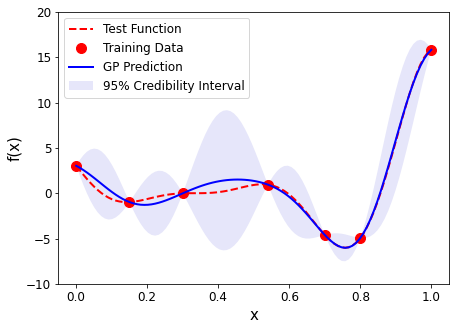

In [10]:
# Assess prediction results
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.plot(X_train,y_train,'ro',markerfacecolor='r', markersize=10, label='Training Data')
ax.plot(X_test,y_pred,'b-', lw=2, label='GP Prediction')
ax.fill_between(X_test.flatten(), y_pred-1.96*np.sqrt(y_pred_SSqr), 
                y_pred+1.96*np.sqrt(y_pred_SSqr),
                facecolor='lavender',label='95% Credibility Interval')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])
ax.legend(loc="upper left",prop={'size': 12});

### 1.5 Generating prediction realizations

Sometimes it is useful to generate realizations of the GP predictions for Monte Carlo simulations. To generate realizations, we treat GP predictions as random variables, following a multivariate normal distribution. Here, we can use `.realizations` method to generate prediction realizations.

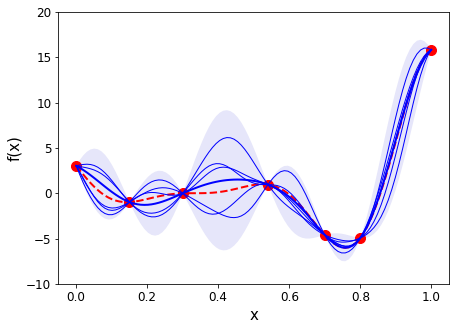

In [11]:
# Generate realizations
samples = GP.realizations(5, X_test)

# Post-processing
fig, ax = plt.subplots(figsize=(7,5))

# True function
ax.plot(X_test,y_test,'r--',linewidth=2)

# Training data
ax.plot(X_train,y_train,'ro',markerfacecolor='r', markersize=10)

# Mean prediction
ax.plot(X_test,y_pred,'b-', lw=2)

# Display realizations
for i in range(samples.shape[0]):
    ax.plot(X_test, samples[i,:],'b-', lw=1)

# Display confidence bands
ax.fill_between(X_test.flatten(), y_pred-1.96*np.sqrt(y_pred_SSqr), 
                y_pred+1.96*np.sqrt(y_pred_SSqr),
                facecolor='lavender')

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20]);

# 2. Two-dimensional analytical function

We further showcase how to train and exploit a GP model for multi-dimensional problems. Here, we consider a task of interpolating a two-dimensional analytical function.

\begin{equation}
y = (1-x_1)^2 + 100(x_2-x_1^2)^2, x_1 \in [-2,2] \; x_2 \in [-1,3]
\end{equation}

In [12]:
# 2D Test function
def Test_2D(X):
    """2D Test Function"""
    
    y = (1-X[:,0])**2 + 100*(X[:,1]-X[:,0]**2)**2
    
    return y

## 2.1 Training/testing dataset

We use **Latin Hypercube Sampling** approach to generate space-filling training samples. For the current case, we use the implementation from [`PyDOE`](https://pythonhosted.org/pyDOE/randomized.html#latin-hypercube) package. Alternatively, you could use [skopt.sampler](https://scikit-optimize.github.io/stable/auto_examples/sampler/initial-sampling-method.html#sphx-glr-auto-examples-sampler-initial-sampling-method-py) package. 

In [13]:
# Training data
sample_num = 30
lb, ub = np.array([-2, -1]), np.array([2, 3])
X_train = (ub-lb)*lhs(2, samples=sample_num) + lb

# Compute labels
y_train = Test_2D(X_train).reshape(-1,1)

# Test data
X1 = np.linspace(-2, 2, 20)
X2 = np.linspace(-1, 3, 20)
X1, X2 = np.meshgrid(X1, X2)
X_test = np.hstack((X1.reshape(-1,1), X2.reshape(-1,1)))
y_test = Test_2D(X_test)

We can plot those training samples in a 2D parameter space

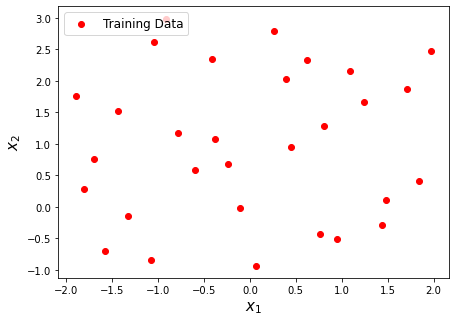

In [14]:
# Vislauzing training samples
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(X_train[:,0], X_train[:,1], c='r', label='Training Data')
ax.set_xlabel(r'$x_1$', fontsize=15)
ax.set_ylabel(r'$x_2$', fontsize=15)
ax.legend(loc="upper left",prop={'size': 12});

### 2.2 GP model training

As in the previous example, we could use `.fit` method to train a GP model. However, we notice that both $x_1$ and $x_2$ are not varying within 0 and 1. To facilitate robust GP model parameter estimation, a common practice is to normalize the inputs such that they vary in $[0,1]$. Here, we use `sklearn.Pipeline` to glue together a scaler (which scales the inputs) and our developed `GPInterpolator` class. 

In [15]:
# GP model training
pipe = Pipeline([('scaler', MinMaxScaler()), 
         ('GP', GPInterpolator(trend='Linear', kernel='Gaussian', 
                               opt={'optimizer': 'L-BFGS-B', 'jac': True},
                               n_restarts=30))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('GP',
                 <GPInterpolator.GPInterpolator object at 0x0000021193961A90>)])

## 2.3 GP model prediction

Then, we make predictions on the test dataset.

In [16]:
# GP model predicting
y_pred, y_pred_SSqr = pipe.predict(X_test)

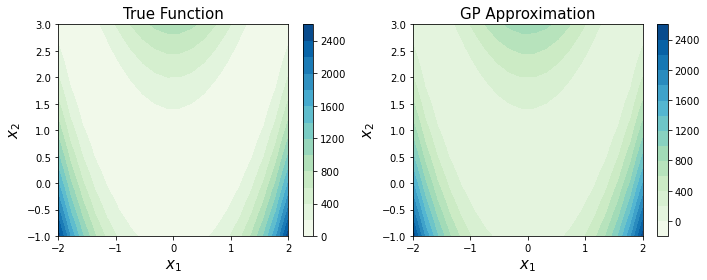

In [17]:
# Post-processing - Contour plot
fig, ax = plt.subplots(1, 2, figsize=(10,4))
title = ['True Function', 'GP Approximation']
display_y = [y_test, y_pred]

for i in range(2):
    h = ax[i].contourf(X_test[:,0].reshape(20,-1), 
                   X_test[:,1].reshape(20,-1), 
                   display_y[i].reshape(20,-1), levels=15, cmap='GnBu');
    ax[i].set_xlabel(r'$x_1$', fontsize=15)
    ax[i].set_ylabel(r'$x_2$', fontsize=15)
    ax[i].set_title(title[i], fontsize=15)
    fig.colorbar(h, ax=ax[i])
plt.tight_layout()

In [18]:
# Assess accuracy score
pipe.score(X_test, y_test)

1.6207240455181184